In [1]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

## Imports Needed to run Notebook

In [2]:
#Imports for data wrangling 
import cudf
import cupy as cp
import pandas as pd
import numpy as np
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
#Importing given data
train = cudf.read_csv("./input/train.csv", parse_dates=['date'])

test = cudf.read_csv("./input/test.csv", parse_dates=['date'])

oil = cudf.read_csv("./input/oil.csv", parse_dates=['date'])

holiday = cudf.read_csv("./input/holidays_events.csv")

store = cudf.read_csv("./input/stores.csv")

## Feature Engineering


### Capturing Seasonal Holiday Effect

In [4]:
# Converting dates to datetime
holiday["date"] = cudf.to_datetime(holiday["date"], format='%Y-%m-%d')
holiday = holiday.set_index("date")

# Keeping only celbrated holidays
holiday = holiday.loc[(holiday["transferred"]!=True)].drop("transferred", axis=1)
holiday.loc[holiday["type"]=="Transfer", "type"] = "Holiday"

# Bridged days are day where there is no work
bridge = holiday.loc[holiday["type"]=="Bridge"]
bridge["bridge"] = True
bridge = bridge[["bridge"]]

# Special events
event = holiday.loc[holiday["type"]=="Event"][["description"]]

# Keeping only holidays
holiday = holiday.loc[holiday["type"]=="Holiday"]

# Holidays celerbated localy 
loc_hol = holiday.loc[holiday["locale"]=="Local"][["locale_name", "description"]]

# Holidays celerbrated regionally
reg_hol = holiday.loc[holiday["locale"]=="Regional"][["locale_name", "description"]]

#Holidays celberbrated nationally
nat_hol = holiday.loc[holiday["locale"]=="National"][["description"]]

# Recording days Earthquake
quake = event.loc[event["description"].str.find("Terremoto Manabi")!=-1]
quake["time_since_quake"] = cp.arange(1,len(quake.index)+1)
quake.drop("description", axis=1, inplace=True)

# Removing Earthquake and adding Sporting Events
event = event.loc[event["description"].str.find("Terremoto Manabi")==-1]
event.loc[event["description"].str.find("futbol")!=-1, "description"]= "Sports"

### Location Specific Demand

In [5]:
# Ensure proper format
train["store_nbr"] = train["store_nbr"].astype(int)

# Merging
X = train.merge(store, on="store_nbr", how="left")
X.drop("cluster", axis=1, inplace=True)

# Converting dates to datetime
X["date"] = cudf.to_datetime(X["date"], format='%Y-%m-%d')

# Creating feature measuring the total in store promotions.
total_other_promo_store = X[["date", "store_nbr", "onpromotion"]].groupby(['date', 'store_nbr']).sum()["onpromotion"].reset_index()
total_other_promo_store = total_other_promo_store.rename(columns={'onpromotion': 'total_other_promo_store',})

# Creating feature measuring the total promotions in each town for similar products.
total_other_city_promo = X[["date", "onpromotion", "family", "city"]].groupby(['date', 'city', 'family']).sum()["onpromotion"].reset_index()
total_other_city_promo = total_other_city_promo.rename(columns={'onpromotion': 'total_other_city_promo',})

# Adding new features
X = X.merge(total_other_promo_store, on=['date', 'store_nbr'], how="left")
X = X.merge(total_other_city_promo, on=['date', 'city', 'family'], how="left")

In [6]:
# Ensure proper format
store["store_nbr"] = store["store_nbr"].astype(int)
test["store_nbr"] = test["store_nbr"].astype(int)

# Merging
X_test = test.merge(store, on="store_nbr", how="left")
X_test.drop("cluster", axis=1, inplace=True)

# Converting dates to datetime
X_test["date"] = cudf.to_datetime(X_test["date"], format='%Y-%m-%d')

# Creating feature measuring the total in store promotions.
total_other_promo_store = X_test[["date", "store_nbr", "onpromotion"]].groupby(['date', 'store_nbr']).sum()["onpromotion"].reset_index()
total_other_promo_store = total_other_promo_store.rename(columns={'onpromotion': 'total_other_promo_store',})

# Creating feature measuring the total promotions in each town for similar products.
total_other_city_promo = X_test[["date", "onpromotion", "family", "city"]].groupby(['date', 'city', 'family']).sum()["onpromotion"].reset_index()
total_other_city_promo = total_other_city_promo.rename(columns={'onpromotion': 'total_other_city_promo',})

# Adding new features
X_test = X_test.merge(total_other_promo_store, on=['date', 'store_nbr'], how="left")
X_test = X_test.merge(total_other_city_promo, on=['date', 'city', 'family'], how="left")

In [7]:
X = X.set_index("date")
X_test = X_test.set_index("date")

### Merging with Holidays

In [8]:
# Adding national holidays
X = X.merge(nat_hol, on="date", how="left")

# Bridge days
X = X.merge(bridge, on="date", how="left")

# Adding local holdays
X = X.merge(loc_hol, left_on=["date", "city"],
            right_on=["date", "locale_name"],
            suffixes=(None, '_l'), how="left"
           )
X.drop("locale_name", axis=1, inplace=True)

# Adding regional holidays
X = X.merge(reg_hol, left_on=["date", "state"],
            right_on=["date", "locale_name"], 
            suffixes=(None, '_r'),how="left"
           )
X.drop("locale_name", axis=1, inplace=True)

# True if holiday that Day
X["holiday"] = (((X["descriptionNone"].isnull()==False) | (X["description_l"].isnull()==False)) | (X["description"].isnull()==False))

# Combine Holiday descriptions
X.drop("descriptionNone", axis=1, inplace=True)
X.drop("description_l", axis=1, inplace=True)
X.drop("description", axis=1, inplace=True)

#Events
X = X.merge(event, on="date", how="left")
X = X.rename(columns={'description': 'event',})
X["event"] = X["event"].fillna("none")

# Adding Quake data
X = X.merge(quake, on="date", how="left")
X["time_since_quake"] = X["time_since_quake"].fillna(0)

#To model a diminishing marginal effect on the economy by the earthquake
X["time_since_quake_sq"] = X["time_since_quake"]**2

In [9]:
# Adding national holidays
X_test = X_test.merge(nat_hol, on="date", how="left")
del nat_hol

# Bridge days
X_test = X_test.merge(bridge, on="date", how="left")
del bridge

# Adding local holdays
X_test = X_test.merge(loc_hol, left_on=["date", "city"],
            right_on=["date", "locale_name"],
            suffixes=(None, '_l'), how="left"
           )
X_test.drop("locale_name", axis=1, inplace=True)
del loc_hol

# Adding regional holidays
X_test = X_test.merge(reg_hol, left_on=["date", "state"],
            right_on=["date", "locale_name"], 
            suffixes=(None, '_r'),how="left"
           )
X_test.drop("locale_name", axis=1, inplace=True)
del reg_hol

# True if holiday that Day
X_test["holiday"] = (((X_test["descriptionNone"].isnull()==False) | (X_test["description_l"].isnull()==False)) | (X_test["description"].isnull()==False))

# Combine Holiday descriptions
X_test.drop("descriptionNone", axis=1, inplace=True)
X_test.drop("description_l", axis=1, inplace=True)
X_test.drop("description", axis=1, inplace=True)

#Events
X_test = X_test.merge(event, on="date", how="left")
X_test = X_test.rename(columns={'description': 'event',})
X_test["event"] = X_test["event"].fillna("none")
del event

# Adding Quake data
X_test = X_test.merge(quake, on="date", how="left")
X_test["time_since_quake"] = X_test["time_since_quake"].fillna(0)
del quake

#To model a diminishing marginal effect on the economy by the earthquake
X_test["time_since_quake_sq"] = X_test["time_since_quake"]**2

### Merging with Oil Prices

In [10]:
oil["date"] = cudf.to_datetime(oil["date"], format='%Y-%m-%d')
oil = oil.set_index("date")
X = X.merge(oil, on="date", how="left")
X_test = X_test.merge(oil, on="date", how="left")

del oil

# There is no price of oil on days that the market is closed.
# To fill the price, we first fill with the last value.
X["dcoilwtico"]= X["dcoilwtico"].interpolate(method="linear", limit_direction="both")
X_test["dcoilwtico"]= X_test["dcoilwtico"].interpolate(method="linear", limit_direction="both")

# X["dcoilwtico"]= X["dcoilwtico"].ffill()
# X_test["dcoilwtico"]= X_test["dcoilwtico"].ffill()

# # We back fill just for first couple values that are empty.
# X["dcoilwtico"]= X["dcoilwtico"].bfill()
# X_test["dcoilwtico"]=X_test["dcoilwtico"].bfill()

# I just to do a rolling average to smooth out any problems with the empty values,
# and to capture any effect of changes. 
X["dcoilwtico"] = X["dcoilwtico"].rolling(
    window=30,       
    min_periods=1,  
).mean()

X_test["dcoilwtico"] = X_test["dcoilwtico"].rolling(
    window=30,       
    min_periods=1,  
).mean()

### Time Based Varriables

In [11]:
# Time variables
X["day"] = X.index.dayofweek
X["dayofyear"] = X.index.dayofyear
X["month"] = X.index.month
X["year"] = X.index.year

# This varible says whether it is a workday.
X["workday"] = (((X.bridge.isnull()) & (X.holiday==False)) & ((X["day"]!=5) & (X["day"]!=6)))
X.drop("bridge", axis=1, inplace=True)

# In Ecudor, people get paid on the 15 and the last day of the month
X["payday"] = ((X.index.day==15) | (X.index.day==X.index.to_series().dt.days_in_month)) 

In [12]:
# Time variables
X_test["day"] = X_test.index.dayofweek
X_test["dayofyear"] =X_test.index.dayofyear
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year

# This varible says whether it is a workday.
X_test["workday"] = (((X_test.bridge.isnull()) & (X_test.holiday==False)) & ((X_test["day"]!=5) & (X_test["day"]!=6)))
X_test.drop("bridge", axis=1, inplace=True)

# In Ecudor, people get paid on the 15 and the last day of the month
X_test["payday"] = ((X_test.index.day==15) | (X_test.index.day==X_test.index.to_series().dt.days_in_month)) 

### Final Dataframe

In [13]:
# Fixing data type
X_test = X_test.reset_index()
X_test = X_test.set_index("date")

X_test["family"] = X_test["family"]
X_test["store_nbr"] = X_test["store_nbr"]
X_test["holiday"] = X_test["holiday"]
X_test["event"] = X_test["event"]
X_test["city"] = X_test["city"]
X_test["state"] = X_test["state"]
X_test["type"] = X_test["type"]
X_test["workday"] = X_test["workday"]
X_test["payday"] = X_test["payday"]

In [14]:
X = X.reset_index()

X = X.set_index("date")

X["family"] = X["family"].astype('category')
X["store_nbr"] = X["store_nbr"].astype('category')
X["holiday"] = X["holiday"].astype('category')
X["event"] = X["event"].astype('category')
X["city"] = X["city"].astype('category')
X["state"] = X["state"].astype('category')
X["type"] = X["type"].astype('category')
X["workday"] = X["workday"].astype('category')
X["payday"] = X["payday"].astype('category')

y = X[["store_nbr", "family", "sales"]]
X.drop("sales", axis=1, inplace=True)

X.head()

,id,store_nbr,family,onpromotion,city,state,type,total_other_promo_store,total_other_city_promo,holiday,event,time_since_quake,time_since_quake_sq,dcoilwtico,day,dayofyear,month,year,workday,payday
date,,,,,,,,,,,,,,,,,,,,
2013-01-06,10192,44,POULTRY,0,Quito,Pichincha,A,0,0,False,none,0,0,93.160011,6,6,1,2013,False,False
2013-01-06,10193,44,PREPARED FOODS,0,Quito,Pichincha,A,0,0,False,none,0,0,93.160022,6,6,1,2013,False,False
2013-01-06,10194,44,PRODUCE,0,Quito,Pichincha,A,0,0,False,none,0,0,93.160034,6,6,1,2013,False,False
2013-01-06,10195,44,SCHOOL AND OFFICE SUPPLIES,0,Quito,Pichincha,A,0,0,False,none,0,0,93.160045,6,6,1,2013,False,False
2013-01-06,10197,45,AUTOMOTIVE,0,Quito,Pichincha,A,0,0,False,none,0,0,93.160056,6,6,1,2013,False,False


In [15]:
# Removing early time with NaNs
X = X.loc[X.index >= "2015-07-01"]
y = y.loc[y.index >= "2015-07-01"]

## Trainning Model
###  Imports

In [16]:
# Data Preprocessing 
from cuml.dask.preprocessing import OneHotEncoder, LabelEncoder
from cuml.preprocessing import MinMaxScaler, StandardScaler, SimpleImputer, LabelEncoder, OneHotEncoder
from cuml.compose import make_column_transformer
from statsmodels.tsa.deterministic import CalendarFourier
from sklearn.pipeline import Pipeline

# Cross-Validation
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.dummy import DummyRegressor
from cuml.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from cuml.metrics import mean_squared_error, mean_squared_log_error
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from jons_time_series_functions import Prepare_data, Hybrid_Pipeline

### Pytorch

In [17]:
# Function to perform a basic operation on the GPU and return the result
def basic_gpu_operation(device):
    # Create a random tensor of size (1000, 1000) on the specified device
    x = torch.rand((1000, 1000), device=device)
    # Perform a basic arithmetic operation (e.g., matrix multiplication with its transpose)
    result = torch.matmul(x, x.t())
    # Return the sum of the result to ensure a scalar value is returned
    return result.sum()

# Check if CUDA is available
if torch.cuda.is_available():
    # Print the total number of GPUs detected
    gpu_count = torch.cuda.device_count()
    print(f'Total GPUs detected: {gpu_count}\n')
    # Initialize a list to hold the results from each GPU
    results = []
    # Loop through all available GPUs, print their properties, perform computations, and gather results
    for i in range(gpu_count):
        device = torch.device(f'cuda:{i}')
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"Device {i}: {gpu_properties.name}")
        print(f"  Total memory: {gpu_properties.total_memory / 1e9} GB")
        print(f"  CUDA Capability: {gpu_properties.major}.{gpu_properties.minor}")
        print(f"  MultiProcessor Count: {gpu_properties.multi_processor_count}")
        print(f'  Performing computation on Device {i}...\n')
        # Perform the basic operation on the GPU and append the result to the results list
        result = basic_gpu_operation(device)
        results.append(result.item())  # Convert to Python number and append
    # Summarize and print the results from each GPU
    print('Summary of Results:')
    for i, result in enumerate(results):
        print(f'Result from GPU {i}: {result:.2f}')
    # Perform some aggregation on the CPU (e.g., compute the average of all results)
    results = cp.array(results)
    average_result = cp.mean(results)
    print(f'\nAverage result from all GPUs: {average_result:.2f}')
    # Optionally, provide a summary of overall GPU utilization or performance here
    # This could involve more detailed metrics based on your specific use case or application
else:
    print("CUDA is not available. Please check your installation.")

Total GPUs detected: 1

Device 0: NVIDIA GeForce RTX 4070
  Total memory: 12.878086144 GB
  CUDA Capability: 8.9
  MultiProcessor Count: 46
  Performing computation on Device 0...

Summary of Results:
Result from GPU 0: 250010800.00

Average result from all GPUs: 250010800.00


In [18]:
class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse=nn.MSELoss().to(device)
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred+1), torch.log(actual + 1))
    
    
class LSTMModel(nn.Module):
    def __init__(self, input_layer, n_hidden_1, n_hidden_2, drop):
        super(LSTMModel, self).__init__()
        
        self.input_layer = input_layer
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        
        # Layers: Linear, LSTM, Linear
        self.linear1 = nn.Linear(input_layer, n_hidden_1)
        self.dropout = nn.Dropout(drop)
        self.lstm = nn.LSTM(n_hidden_1, n_hidden_2, batch_first=True)
        self.linear2 = nn.Linear(n_hidden_2, 1)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        
        x = self.linear1(x)
        x = self.dropout(x)
        
        output, (h_t, c_t) = self.lstm(x)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.ReLU(output)
        return output


class LSTMRegressor():
    def __init__(self, n_hidden=50, n_hidden_2=20, drop=0.2, epochs=100, early_stop=5, lr=0.01, Boosted=False):
        
        self.n_hidden = n_hidden
        self.n_hidden_2 = n_hidden_2
        self.drop = drop
        if Boosted:
            self.criterion = nn.MSELoss().to(device)
        else: 
            self.criterion = MSLELoss()
            
        self.early_stop = early_stop 
        self.epochs = epochs 
        self.lr = lr
        self.min_val_loss = float('inf')
        self.min_val_loss_2 = float('inf')
        
    def train(self, train_loader):
        
        self.model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch, y_batch

            self.optimizer.zero_grad()
            outputs = self.model(x_batch)
            loss = self.criterion(outputs, y_batch)
            loss.backward()
            self.optimizer.step()


    def pred(self, test_loader, valid=False, epoch=0):
        
        self.model.eval()
        if valid:
             
            val_losses = 0
            num = 0
            
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch
                    outputs = self.model(x_batch)

                    loss = self.criterion(outputs, y_batch)
                    val_losses=+loss.item()

                    num=+1

            val_loss = val_losses/num

            if val_loss<self.min_val_loss:
            
                self.min_val_loss = val_loss
                self.early_stop_count = 0
            else:
                self.early_stop_count+=1
            
            print(f"Epoch {epoch+1}/{self.epochs}, Validation score of {np.sqrt(val_loss):.4f}")
            if self.early_stop_count>=self.early_stop:
                print(f"early stopping at Validation Score of {np.sqrt(self.min_val_loss):.4f}")
                print()
                self.stop = True

            
            
        else:
            
            with torch.no_grad():
                predictions = []
                for x_batch in test_loader:
                    x_batch = x_batch.to(device)
                    outputs = self.model(x_batch)
                    predictions.append(outputs.cpu().numpy())

                return np.concatenate(predictions)
                
    def fit(self, X, y):
        
        
        if isinstance(X, list):
            X_train, y_train = X[0], y[0]
            self.model = LSTMModel(X_train.shape[1], n_hidden_1=self.n_hidden, n_hidden_2= self.n_hidden_2, drop=self.drop).to(device)
            
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
            train_loader = DataLoader(TensorDataset(X_train.to(device), y_train.to(device)), batch_size=31, shuffle=False)
            
            X_valid, y_valid = X[1], y[1]
            test_loader = DataLoader(TensorDataset(X_valid.to(device), y_valid.to(device)), batch_size=31, shuffle=False)
            
            self.stop=False
            self.early_stop_count =0 
            
            for epoch in range(self.epochs):
                self.train(train_loader)
                
                self.pred(test_loader, valid=True, epoch=epoch)
                if self.stop:
                    break

        else:
                X_train, y_train = X, y
                self.model = LSTMModel(X_train.shape[1], n_hidden_1=self.n_hidden, n_hidden_2= self.n_hidden_2, drop=self.drop).to(device)
                
                self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
                train_loader = DataLoader(TensorDataset(X_train.to(device), y_train.to(device)), batch_size=31, shuffle=False)
                
                for epoch in range(self.epochs):
                    self.train(train_loader)
    
    def predict(self, X):
        
        test_loader = DataLoader(X.to(device), batch_size=31, shuffle=False)
        
        outputs = self.pred(test_loader)
        
        return outputs

### Trainning

In [19]:
# Define the preprocessing steps
numeric_transformer = [['dcoilwtico', 'onpromotion', 'total_other_promo_store', 'total_other_city_promo'], StandardScaler()]
categorical_transformer = [['event', "store_nbr", "family"], OneHotEncoder(sparse=False, handle_unknown='ignore')]

column_list = ["time_since_quake", "time_since_quake_sq"]

#data_preprocessor = Prepare_data(column_list, [numeric_transformer, categorical_transformer])
data_preprocessor = Prepare_data(column_list, [numeric_transformer])

In [20]:
X_C = X.copy().drop(["state", "city", "type", "dayofyear", "year"], axis=1)


# X_C["family"] = X_C["family"].cat.codes
# X_C["store_nbr"] = X_C["store_nbr"].cat.codes
# X["holiday"] = X_C["holiday"].cat.codes
# X_C["event"] = X["event"].cat.codes
# X_C["city"] = X_C["city"].cat.codes
# X_C["state"] = X_C["state"].cat.codes
# X_C["type"] = X_C["type"].cat.codes

X_C = X_C.reset_index().sort_values(["store_nbr", "family", "date"])
y = y.reset_index().sort_values(["store_nbr", "family", "date"])
X_C = X_C.set_index(["date"])
y = y.set_index(["date"])

In [21]:
X_test_C = X_test.copy().drop(["state", "city", "type", "dayofyear", "year"], axis=1)
X_test_C = X_test_C.reset_index().sort_values(["store_nbr", "family", "date"])
X_test_C = X_test_C.set_index(["date"])

## Linear Regression, XGBoost, Boosted

In [41]:
def feature_importance(X, y, model):
    
    dates = X.index.drop_duplicates()
    
    X_train = X.loc[dates[int(len(dates)*2/3):]]
    X_valid = X.loc[dates[:int(len(dates)*2/3)]]
    
    y_train = y.loc[dates[int(len(dates)*2/3):]]
    y_valid = y.loc[dates[:int(len(dates)*2/3)]]
    
    model.fit(X_train, y_train)
    
    del X_train
    del y_train
    
    pred = model.predict(X_valid)
    baseline = float(np.sqrt(mean_squared_log_error(y_valid.sales, pred.sales)))
    importance_dict = {}
    
    for i in range(1, len(X_valid.columns)):
        
        name = X_valid.columns[i]
        X_shuffle = X_valid.copy()
        X_shuffle = X_shuffle.to_pandas()
        X_shuffle[name] = X_shuffle[name].values[np.random.permutation(len(X_shuffle))]
        
        X_shuffle = cudf.from_pandas(X_shuffle)
        pred = model.predict(X_shuffle)
        
        del X_shuffle
        
        importance_dict[name] = float(np.sqrt(mean_squared_log_error(y_valid.sales, pred.sales))) - baseline
        
        
    return importance_dict
        

<Axes: title={'center': 'Feature Importance'}, ylabel='Columns'>

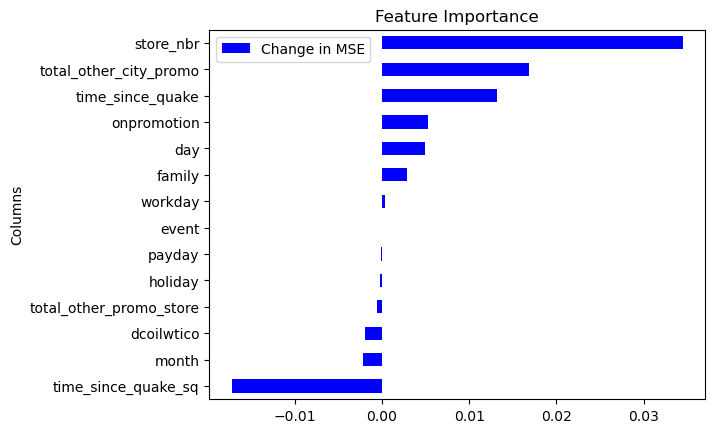

In [46]:
xgb_params = {
    'tree_method': 'gpu_hist',  # Specify GPU usage
    'predictor': 'gpu_predictor',
    'enable_categorical': True,
}

xgb = XGBRegressor(**xgb_params)


lr = LinearRegression(fit_intercept=False, algorithm="svd", copy_X=True)

data_preprocessor = Prepare_data(column_list, [numeric_transformer])

model = Hybrid_Pipeline(data_preprocessor, lr, xgb, Boosted=True, to_tensor=False)

feature_df = pd.DataFrame.from_dict(feature_importance(X_C, y, model), orient='index', columns=['Effect on MSE']).reset_index().sort_values("Change in MSE")
feature_df = feature_df.rename({"index": "Columns"}, axis=1)
feature_df.plot.barh(x='Columns', y='Change in MSE', title='Feature Importance', color='blue')

In [ ]:
def hyperparameter_optimization(n_estimators, gamma, subsample, max_depth, learning_rate):
    
    
    model_1 = LinearRegression(fit_intercept=False, algorithm="svd", copy_X=True)
    
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    params = {
    'tree_method': 'gpu_hist',  # Specify GPU usage
    'predictor': 'gpu_predictor',
    'enable_categorical': True,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'gamma': gamma,
    'subsample': subsample}

    model_2 = XGBRegressor(**params)
    # Use time series split for cross validation. 
    cv_split = TimeSeriesSplit(n_splits = 4)
    
    # Create lists to append MSLE scores.
    valid_msle = []

    # Dates to index through. 
    dates = X_C.index.drop_duplicates()

    
    # Perform Cross-Validation to determine how model will do on unseen data.
    for train_index, valid_index in cv_split.split(dates):

        model = Hybrid_Pipeline(data_preprocessor, model_1, model_2, Boosted=True, to_tensor=False)

        # Index dates.
        date_train, date_valid = dates[train_index], dates[valid_index]

        # Selecting data for y_train and y_valid.
        y_train = y.loc[date_train]
        y_valid = y.loc[date_valid]

        # Selecting data for X_train and X_valid.
        X_train = X_C.loc[date_train]
        X_valid = X_C.loc[date_valid]

        X_train = X_train.reset_index().sort_values(["store_nbr", "family", "date"])
        X_valid = X_valid.reset_index().sort_values(["store_nbr", "family", "date"])
        X_train = X_train.set_index(["date"])
        X_valid = X_valid.set_index(["date"])

        y_train = y_train.reset_index().sort_values(["store_nbr", "family", "date"])
        y_valid = y_valid.reset_index().sort_values(["store_nbr", "family", "date"])
        y_train = y_train.set_index(["date"])
        y_valid = y_valid.set_index(["date"])


        # Fitting model.
        model.fit(X_train, y_train)

        # Create predictions for Trainning and Validation.
        pred = model.predict(X_valid)

        # MSE for trainning and validation. 
        valid_msle.append(float(mean_squared_log_error(y_valid["sales"], pred["sales"])))


    return -float(np.sqrt(np.mean(valid_msle)))

In [ ]:
parambounds = {
    'learning_rate': (0.00001, 1),
    'n_estimators': (0, 500),
    'max_depth': (3,12),
    'subsample': (0.0001, 1.0),  
    'gamma': (3, 8),
    
}

optimizer = BayesianOptimization(
    f=hyperparameter_optimization,
    pbounds=parambounds,
    random_state=1,
)

optimizer.maximize(init_points=20, n_iter=30,)
print(optimizer.max)

In [ ]:
params = optimizer.max["params"]

xgb_params = {
    'tree_method': 'gpu_hist',  # Specify GPU usage
    'predictor': 'gpu_predictor',
    'enable_categorical': True,
    'max_depth': int(params["max_depth"]),
    'learning_rate': params["learning_rate"],
    'n_estimators': int(params["n_estimators"]),
    'gamma': params["gamma"],
    'subsample': params["subsample"]
}

xgb = XGBRegressor(**xgb_params)


lr = LinearRegression(fit_intercept=False, algorithm="svd", copy_X=True)

data_preprocessor = Prepare_data(column_list, [numeric_transformer])

In [ ]:
# Use time series split for cross validation. 
cv_split = TimeSeriesSplit(n_splits = 4)

# Create lists to append MSE scores. 
train_msle = []
valid_msle = []

# Dates to index through. 
dates = X_C.index.drop_duplicates()
a = 0
# Perform Cross-Validation to determine how model will do on unseen data.
for train_index, valid_index in cv_split.split(dates):
    a = a+1
    print(f"Fold {a}:") 
    model = Hybrid_Pipeline(data_preprocessor, lr, xgb, Boosted=True, to_tensor=False)
    
    # Index dates.
    date_train, date_valid = dates[train_index], dates[valid_index]

    # Selecting data for y_train and y_valid.
    y_train = y.loc[date_train]
    y_valid = y.loc[date_valid]
    
    # Selecting data for X_train and X_valid.
    X_train = X_C.loc[date_train]
    X_valid = X_C.loc[date_valid]
    
    X_train = X_train.reset_index().sort_values(["store_nbr", "family", "date"])
    X_valid = X_valid.reset_index().sort_values(["store_nbr", "family", "date"])
    X_train = X_train.set_index(["date"])
    X_valid = X_valid.set_index(["date"])

    y_train = y_train.reset_index().sort_values(["store_nbr", "family", "date"])
    y_valid = y_valid.reset_index().sort_values(["store_nbr", "family", "date"])
    y_train = y_train.set_index(["date"])
    y_valid = y_valid.set_index(["date"])


    # Fitting model.
    model.fit(X_train, y_train)

    # Create predictions for Trainning and Validation.
    fit = model.predict(X_train)
    pred = model.predict(X_valid)
    
    # MSE for trainning and validation. 
    train_msle.append(float(mean_squared_log_error(y_train["sales"], fit["sales"])))
    valid_msle.append(float(mean_squared_log_error(y_valid["sales"], pred["sales"])))
    
    print(f"Training RMSLE: {cp.sqrt(mean_squared_log_error(y_train.sales, fit.sales)):.3f}, Validation RMSLE: {cp.sqrt(mean_squared_log_error(y_valid.sales, pred.sales)):.3f}")

# Returns the square root of the average of the MSE.
print("Average Across Folds")
print(f"Training RMSLE:{np.sqrt(np.mean(train_msle)):.3f}, Validation RMSLE: {np.sqrt(np.mean(valid_msle)):.3f}")

e_1 = 1/np.sqrt(np.mean(valid_msle))

In [ ]:
# Fit Model
model = Hybrid_Pipeline(data_preprocessor, lr, xgb, Boosted=True, to_tensor=False)
model.fit(X_C, y)

pred_1 = model.predict(X_test_C)

## Linear Regression, XGBoost, Stacked

In [ ]:
def hyperparameter_optimization(n_estimators, gamma, subsample, max_depth, learning_rate):
    
    
    model_1 = LinearRegression(fit_intercept=False, algorithm="svd", copy_X=True)
    
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    params = {
    'tree_method': 'gpu_hist',  # Specify GPU usage
    'predictor': 'gpu_predictor',
    'enable_categorical': True,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'gamma': gamma,
    'subsample': subsample}

    model_2 = XGBRegressor(**params)
    # Use time series split for cross validation. 
    cv_split = TimeSeriesSplit(n_splits = 4)
    
    # Create lists to append MSLE scores.
    valid_msle = []

    # Dates to index through. 
    dates = X_C.index.drop_duplicates()

    
    # Perform Cross-Validation to determine how model will do on unseen data.
    for train_index, valid_index in cv_split.split(dates):

        model = Hybrid_Pipeline(data_preprocessor, model_1, model_2, Boosted=False, to_tensor=False)

        # Index dates.
        date_train, date_valid = dates[train_index], dates[valid_index]

        # Selecting data for y_train and y_valid.
        y_train = y.loc[date_train]
        y_valid = y.loc[date_valid]

        # Selecting data for X_train and X_valid.
        X_train = X_C.loc[date_train]
        X_valid = X_C.loc[date_valid]

        X_train = X_train.reset_index().sort_values(["store_nbr", "family", "date"])
        X_valid = X_valid.reset_index().sort_values(["store_nbr", "family", "date"])
        X_train = X_train.set_index(["date"])
        X_valid = X_valid.set_index(["date"])

        y_train = y_train.reset_index().sort_values(["store_nbr", "family", "date"])
        y_valid = y_valid.reset_index().sort_values(["store_nbr", "family", "date"])
        y_train = y_train.set_index(["date"])
        y_valid = y_valid.set_index(["date"])


        # Fitting model.
        model.fit(X_train, y_train)

        # Create predictions for Trainning and Validation.
        pred = model.predict(X_valid)

        # MSE for trainning and validation. 
        valid_msle.append(float(mean_squared_log_error(y_valid["sales"], pred["sales"])))


    return -float(np.sqrt(np.mean(valid_msle)))

In [ ]:
parambounds = {
    'learning_rate': (0.00001, 1),
    'n_estimators': (0, 500),
    'max_depth': (3,12),
    'subsample': (0.0001, 1.0),  
    'gamma': (3, 8),
    
}

optimizer = BayesianOptimization(
    f=hyperparameter_optimization,
    pbounds=parambounds,
    random_state=1,
)

optimizer.maximize(init_points=20, n_iter=30,)
print(optimizer.max)

In [ ]:
params = optimizer.max["params"]

xgb_params = {
    'tree_method': 'gpu_hist',  # Specify GPU usage
    'predictor': 'gpu_predictor',
    'enable_categorical': True,
    'max_depth': int(params["max_depth"]),
    'learning_rate': params["learning_rate"],
    'n_estimators': int(params["n_estimators"]),
    'gamma': params["gamma"],
    'subsample': params["subsample"]
}

xgb = XGBRegressor(**xgb_params)


model_1 = LinearRegression(fit_intercept=False, algorithm="svd", copy_X=True)

In [ ]:
# Use time series split for cross validation. 
cv_split = TimeSeriesSplit(n_splits = 4)

# Create lists to append MSE scores. 
train_msle = []
valid_msle = []

# Dates to index through. 
dates = X_C.index.drop_duplicates()
a = 0
# Perform Cross-Validation to determine how model will do on unseen data.
for train_index, valid_index in cv_split.split(dates):
    a = a+1
    print(f"Fold {a}:") 
    model = Hybrid_Pipeline(data_preprocessor, lr, xgb, Boosted=False, to_tensor=False)
    
    # Index dates.
    date_train, date_valid = dates[train_index], dates[valid_index]

    # Selecting data for y_train and y_valid.
    y_train = y.loc[date_train]
    y_valid = y.loc[date_valid]
    
    # Selecting data for X_train and X_valid.
    X_train = X_C.loc[date_train]
    X_valid = X_C.loc[date_valid]
    
    X_train = X_train.reset_index().sort_values(["store_nbr", "family", "date"])
    X_valid = X_valid.reset_index().sort_values(["store_nbr", "family", "date"])
    X_train = X_train.set_index(["date"])
    X_valid = X_valid.set_index(["date"])

    y_train = y_train.reset_index().sort_values(["store_nbr", "family", "date"])
    y_valid = y_valid.reset_index().sort_values(["store_nbr", "family", "date"])
    y_train = y_train.set_index(["date"])
    y_valid = y_valid.set_index(["date"])


    # Fitting model.
    model.fit(X_train, y_train)

    # Create predictions for Trainning and Validation.
    fit = model.predict(X_train)
    pred = model.predict(X_valid)
    
    # MSE for trainning and validation. 
    train_msle.append(float(mean_squared_log_error(y_train["sales"], fit["sales"])))
    valid_msle.append(float(mean_squared_log_error(y_valid["sales"], pred["sales"])))
    
    print(f"Training RMSLE: {cp.sqrt(mean_squared_log_error(y_train.sales, fit.sales)):.3f}, Validation RMSLE: {cp.sqrt(mean_squared_log_error(y_valid.sales, pred.sales)):.3f}")

# Returns the square root of the average of the MSE.
print("Average Across Folds")
print(f"Training RMSLE:{np.sqrt(np.mean(train_msle)):.3f}, Validation RMSLE: {np.sqrt(np.mean(valid_msle)):.3f}")

e_2 = 1/np.sqrt(np.mean(valid_msle))

In [ ]:
# Fit Model
model = Hybrid_Pipeline(data_preprocessor, lr, xgb, Boosted=True, to_tensor=False)
model.fit(X_C, y)

pred_2 = model.predict(X_test_C)

## Final Predictions and Submission 

In [ ]:
# Generate Predictions
e_sum = e_1+e_2

ensembled_pred = pred_1*e_1/e_sum + pred_2*e_2/e_sum
pred.head()

In [ ]:
ensembled_pred.to_csv('submission.csv', index=True)

In [ ]:
api.competition_submit('submission.csv','1st API Submission','store-sales-time-series-forecasting')